# Train a convolutional neural network to predict MHC ligands
The notebook consists of the following sections:

0. Module imports, define functions, set constants
1. Load Data
2. Build Model
3. Select Hyper-paramerters
4. Instantiate
5. Train Model
6. Evaluation

## Exercise
This exercise will be following the FFNN exercise closely. We will write a function that performs convolutions on a 1D input (i.e. a sequence) across the temporal dimension (i.e. the positions in the sequence). The outputs of the convolution will then be passed to an FFNN that will output a predicted binding affinity value as in the previous exercise. As we have already implemented the FFNN we only need to write the convolution function and then connect it with the FFNN code, using a global max pooling operation.

The CNN architecture is more complex than the FFNN and consequently requires a more efficient implementation in order for it to not be slow to train. Particularly, here we will make use of NumPy's broadcasting functionalities, in order to reduce the number of slow for-loops and multiplication operations we have to make during the forward and backwards passes. You can read more about broadcasting here: https://numpy.org/doc/stable/user/basics.broadcasting.html. At each step that requires loops you should implement the intuitive version of the operations, ensure that your model trains, and subsequently use the more efficient vectorized versions that is provided for each step.



In [1]:
import numpy as np
import pandas as pd
import math
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Utility functions

In [2]:
# Utility functions you will re-use
# Data-related utility functions
def load_blosum(filename):
    """
    Read in BLOSUM values into matrix.
    """
    aa = ['A', 'R', 'N' ,'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    df = pd.read_csv(filename, sep='\s+', comment='#', index_col=0)
    return df.loc[aa, aa]

def load_peptide_target(filename):
    """
    Read amino acid sequence of peptides and
    corresponding log transformed IC50 binding values from text file.
    """
    df = pd.read_csv(filename, sep='\s+', usecols=[0,1], names=['peptide','target'])
    return df.sort_values(by='target', ascending=False).reset_index(drop=True)

def encode_peptides(X_in, blosum_file, max_pep_len=9):
    """
    Encode AA seq of peptides using BLOSUM50.
    Returns a tensor of encoded peptides of shape (1, max_pep_len, n_features) for a single batch
    """
    blosum = load_blosum(blosum_file)
    
    batch_size = len(X_in)
    n_features = len(blosum)
    
    X_out = np.zeros((batch_size, max_pep_len, n_features), dtype=np.int8)
    
    for peptide_index, row in X_in.iterrows():
        for aa_index in range(len(row.peptide)):
            X_out[peptide_index, aa_index] = blosum[ row.peptide[aa_index] ].values
            
    return X_out, np.expand_dims(X_in.target.values,1)


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/zv/33b_cxqd65s540bqz2grpnqh0000gp/T/ipykernel_15738/3282074680.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filename, sep='\s+', comment='#', index_col=0)
/var/folders/zv/33b_cxqd65s540bqz2grpnqh0000gp/T/ipykernel_15738/3282074680.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filename, sep='\s+', usecols=[0,1], names=['peptide','target'])


In [3]:
# Misc. functions
def invoke(early_stopping, loss, model, implement=False):
    if implement == False:
        return False
    else:
        early_stopping(loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            return True
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_losses(train_losses, valid_losses, n_epochs):
    # Plotting the losses 
    fig,ax = plt.subplots(1,1, figsize=(9,5))
    ax.plot(range(n_epochs), train_losses, label='Train loss', c='b')
    ax.plot(range(n_epochs), valid_losses, label='Valid loss', c='m')
    ax.legend()
    fig.show()

In [4]:
# Model saving and loading functions

def save_cnn_model(filepath, model):
    if not filepath.endswith('.pkl'):
        filepath = filepath+'.pkl'
    with open(filepath, 'wb') as f:
        dict_to_save = {'kernel_size': model.filter.shape[0], 'input_size': model.filter.shape[1], 'out_channels': model.filter.shape[2], 'fnn_hidden_size':model.fnn.W1.shape[1], 'output_size':model.fnn.W2.shape[1],
                        'W1': model.fnn.W1, 'b1':model.fnn.b1, 'W2':model.fnn.W2, 'b2':model.fnn.b2, "filter": model.filter,}
        pickle.dump(dict_to_save, f)
        print(f'Saved CNN model at {filepath}')


def load_cnn_model(filepath, model=None):

    with open(filepath, 'rb') as f:
        loaded_dict = pickle.load(f)
    if model is None:
            model = SimpleCNN(loaded_dict['kernel_size'], loaded_dict['input_size'], loaded_channels['out_channels'], loaded_dict['fnn_hidden_size'], loaded_dict['output_size'])
    assert (model.filter.shape[0]==loaded_dict['kernel_size'] and model.filter.shape[1]==loaded_dict['input_size'] and model.filter.shape[2]==loaded_dict['out_channels'] and model.fnn.W1.shape[1]==loaded_dict['fnn_hidden_size'] and model.fnn.W2.shape[1]==loaded_dict['output_size']), \
        f"Model and loaded weights size mismatch!. Provided model has weight of dimensions {model.fnn.W1.shape, model.fnn.W2.shape, model.filter.shape} ; Loaded weights have shape {loaded_dict['W1'].shape, loaded_dict['W2'].shape, loaded_dict['filter'].shape}"

    model.fnn.W1 = loaded_dict['W1']
    model.fnn.b1 = loaded_dict['b1']
    model.fnn.W2 = loaded_dict['W2']
    model.fnn.b2 = loaded_dict['b2']
    model.filter = loaded_dict['filter']
    print(f"Model loaded successfully from {filepath}\nwith weights [ W1, W2, filter] dimensions : {model.fnn.W1.shape, model.fnn.W2.shape, model.filter.shape}")
    return model

# Data loading and encoding

In [5]:
# Replace your data paths with the actual paths and desired alleles
ALLELE =  'A0301' #'A0201'
DATAPATH = '/Users/sendel/teaching/22125/data'
blosum_file = f'{DATAPATH}/BLOSUM50'
train_data = f'{DATAPATH}/{ALLELE}/train_BA'
valid_data = f'{DATAPATH}/{ALLELE}/valid_BA'
test_data = f'{DATAPATH}/{ALLELE}/test_BA'

# Loading the peptides.
train_raw = load_peptide_target(train_data)
valid_raw = load_peptide_target(valid_data)
test_raw = load_peptide_target(test_data)
# 
print('Preview of the dataframe ; Peptides have to be *encoded* to BLOSUM matrices')
display(train_raw.head())

print('N_datapoints:')
print('Train data:\t', train_raw.shape[0])
print('Valid data:\t', valid_raw.shape[0])
print('Test data:\t', test_raw.shape[0])

print('Maximum peptide length of each data set:')
print('Train:\t',  train_raw['peptide'].apply(len).max())
print('Valid:\t', valid_raw['peptide'].apply(len).max())
print('Test:\t', test_raw['peptide'].apply(len).max())

Preview of the dataframe ; Peptides have to be *encoded* to BLOSUM matrices


,peptide,target
0,ATSTRHPSK,1.0
1,RSYSPRNSR,1.0
2,ALYYVHSLLY,1.0
3,LVKSSFVKK,1.0
4,VTFRERYSYK,1.0


N_datapoints:
Train data:	 3951
Valid data:	 1329
Test data:	 1321
Maximum peptide length of each data set:
Train:	 11
Valid:	 11
Test:	 11


Peptide encoding : 

We need to ensure that every peptide shorter than the maximum length `max_len_pep` are *padded* to that length when building the matrices, in order for the dimensions to fit. For example, if our `max_pep_len` is 11, then every peptide of length shorter than 11 must be padded to 11. 

For example, for a peptide "GILGFVFTL", of size 9, and a `max_pep_len` of 11, this effectively means that the peptide is first padded to 11 : "GILGFVFTLXX", where "x" means a pad, and then converted to a matrix.



In [6]:
max_pep_len = train_raw.peptide.apply(len).max()
x_train_, y_train_ = encode_peptides(train_raw, blosum_file, max_pep_len)
x_valid_, y_valid_ = encode_peptides(valid_raw, blosum_file, max_pep_len)
x_test_, y_test_ = encode_peptides(test_raw, blosum_file, max_pep_len)
# We now have matrices of shape (N_datapoints, max_pep_len, n_features)
print(x_train_.shape)

(3951, 11, 21)


# Model definition

Now it's your turn. We are using a class structure, where a class contains `methods` needed for the forward pass (that just means functions that belong to a class) and you will code the derivatives and backpropagation separately.

For the forward pass, you will need to define the shape of your weight and bias matrices, as well as the actual `forward` pass in terms of matrix multiplications. Additionally, as we are using neural networks, you will also need to code the activation functions (ReLU and Sigmoid).

In [7]:
# Weights initialization function.
# xavier initialization is technically more stable and preferred 
# (See slides)
def xavier_initialization_normal(kernel_size, in_channels, out_channels):
    shape = (kernel_size, in_channels, out_channels)
    fan_in = kernel_size * in_channels
    fan_out = kernel_size * out_channels
    stddev = np.sqrt(2 / (fan_in + fan_out))
    return np.random.normal(0, stddev, size=shape)

def random_initialization_normal(input_dim, output_dim):
    return np.random.randn(input_dim, output_dim) * 0.1

In [13]:
def train_network(net, x_train, y_train, learning_rate):
    """
    Trains the network for a single epoch, running the forward and backward pass, and compute and return the loss.
    """
    # Forward pass
    conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2,  = net.forward(x_train)
    # backward pass
    backward(net, x_train, y_train, conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2, learning_rate)
    loss = np.mean((a2 - y_train) ** 2)
    return loss
        
def eval_network(net, x_valid, y_valid):
    """
    Evaluates the network ; Note that we do not update weights (no backward pass)
    """
    conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2, = net.forward(x_valid)
    loss = np.mean((a2-y_valid)**2)
    return loss


# Now create a model and run it.

Play around with the hyperparameters (number of epochs, learning rate, hidden size) and see what the changes do!

In [9]:
# FFN part
class SimpleFFNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases with small random values
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros(output_size)
    
    def relu(self, x):
        return np.maximum(0, x)

    # This version of sigmoid here is NOT numerically stable.
    # We need to split the cases where the input is positive or negative
    # because np.exp(-x) for something negative will quickly overflow if x is a large negative number
    # def sigmoid(self, x):
    #     return 1 / (1 + np.exp(-x))

    def sigmoid(self, x): 
        # This is equivalent to : 
        # if x>=0, then compute (1/(1+np.exp(-x)))
        # else: compute (np.exp(x)/(1+np.exp(x))))
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))

    def forward(self, x):
        """
        zi denotes the output of a hidden layer i
        ai denotes the output of an activation function at layer i
        (activations are relu, sigmoid, tanh, etc.)
        """

        # First layer
        z1 = np.dot(x, self.W1) + self.b1
        a1 = self.relu(z1)
        
        # Output layer
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.sigmoid(z2)
        
        # Return all the intermediate outputs as well because we need them for backpropagation (see slides)
        return z1, a1, z2, a2


class SimpleCNN:
    def __init__(self, kernel_size, in_channels, out_channels, hidden_size, output_size):
        self.filter = xavier_initialization_normal(kernel_size, in_channels, out_channels)
        self.fnn = SimpleFFNN(out_channels, hidden_size, output_size)

    def conv1d(self, batch_x):
        batch_size, input_length, in_channels = batch_x.shape
        kernel_size, _, out_channels = self.filter.shape
        output_length = input_length - kernel_size + 1
        batch_output = np.zeros((batch_size, output_length, out_channels))

        # First implement the convolution operation in an explicit way
        for i in range(output_length):
            for k in range(out_channels):
                for j in range(kernel_size):
                    # Extract the slice of input for the current position
                    input_slice = batch_x[:, XX, :]

                    # Multiply the the input and filter element-wise and sum over in_channels
                    batch_output[:, i, k] += np.XX(XX * XX[XX, :, XX], axis=1)

        # Then use the numpy broadcasting to vectorize the operation instead
        # for i in range(output_size):
        #     batch_output[:, i, :] = np.sum(batch_x[:, i:i + kernel_size, :, None] * self.filter, axis=(1, 2))
    
        return batch_output

    def relu(self, x):
        return np.maximum(0, x)

    def global_max_pooling(self, x):
        # Find the maximum value for each feature map and its index
        pool_indices = XX
        max_pool = XX
        return max_pool, pool_indices

    def forward(self, x):
        # Pass the input through the convolution layer
        conv_output = XX
        # Apply global max pooling
        pooled_output, pool_indices = XX
        # Apply the ReLU activation function
        relu_output = XX
        
        # Pass the result through the feedforward neural network
        return conv_output, pooled_output, pool_indices, relu_output, *self.XX(XX)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid_derivative(x):
    return x * (1 - x)

def backward(net, x, y, conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2, learning_rate=0.01):
    
    # Backwards pass for the FFNN
    error = a2 - y
    d_output = error * sigmoid_derivative(a2)

    d_W2 = np.dot(a1.T, d_output)
    d_b2 = np.sum(d_output, axis=0, keepdims=True)

    error_hidden_layer = np.dot(d_output, net.fnn.W2.T)
    d_hidden_layer = error_hidden_layer * relu_derivative(a1)

    d_W1 = np.dot(relu_output.T, d_hidden_layer)
    d_b1 = np.sum(d_hidden_layer, axis=0, keepdims=True)

    # Propagate the error back to the pooled layer
    d_pool = XX

    batch_size, input_length, in_channels = x.shape
    kernel_size, in_channels, out_channels = net.filter.shape
    d_conv = np.zeros_like(conv_output)
    for b in range(batch_size):
        # Loop through each output channel
        for c in range(out_channels):
            # Get the index of the maximum value in the pooled output for this sample and channel
            max_index = pool_indices[XX, XX]
            # Propagate the gradient to the position before pooling and apply the ReLU derivative
            d_conv[XX, XX, XX] = d_pool[XX, XX] * relu_derivative(pooled_output[XX, XX])
        
    # Then use this solution for the vectorized version
    # batch_indices = np.arange(len(x))[:, None]
    # channel_indices = np.arange(net.filter.shape[2])[None, :]
    # d_conv[batch_indices, pool_indices, channel_indices] = d_pool * relu_derivative(pooled_output)

    # Calculate the gradient for the convolution filter. First provide a solution for the explicit loop version
    # Loop through each sample in the batch
    d_filter = np.zeros_like(net.filter)
    for b in range(batch_size):
        # Loop through each position in the convolution output
        for i in range(x.shape[1] - d_filter.shape[0] + 1):
            # Extract the input slice corresponding to the current position
            input_slice = XX
            # Accumulate the gradient for the filter by multiplying the input slice with the corresponding gradient
            for j in range(kernel_size):
                for k in range(out_channels):
                    d_filter[XX, :, XX] += input_slice[XX, :] * d_conv[XX, XX, XX]
    
    # Then use this solution for the vectorized version
    # d_filter = np.zeros_like(net.filter)
    # for b in range(len(x)):
    #     for i in range(d_conv.shape[1]):
    #         d_filter += x[b, i:i + net.filter.shape[0], :, None] * d_conv[b, i, None, :]

    # Update the filter weights and the weights and biases of the FFNN
    net.filter -= XX
    net.fnn.W1 -= learning_rate * d_W1
    net.fnn.b1 -= learning_rate * d_b1.squeeze()
    net.fnn.W2 -= learning_rate * d_W2
    net.fnn.b2 -= learning_rate * d_b2.squeeze()

In [43]:
# Define sizes
input_size = x_train_.shape[2] # also known as "n_features"

# Model and training hyperparameters
learning_rate = 0.0001
hidden_units = 32
out_channels = 32
kernel_size = 5
n_epochs = 500
output_size = 1
# Creating a model instance 

# Neural Network training here
network = SimpleCNN(kernel_size=kernel_size, in_channels=input_size, out_channels=out_channels, 
                    hidden_size=hidden_units, output_size=output_size)

In [44]:
# Training loops
train_losses = []
valid_losses = []

# Run n_epochs of training
for epoch in range(n_epochs):
    train_loss = train_network(network, x_train_, y_train_, learning_rate)
    valid_loss = eval_network(network, x_valid_, y_valid_)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # For the first, every 5% of the epochs and last epoch, we print the loss 
    # to check that the model is properly training. (loss going down)
    if (n_epochs >= 10 and epoch % math.ceil(0.05 * n_epochs) == 0) or epoch == 0 or epoch == n_epochs:
        print(f"Epoch {epoch}: \n\tTrain Loss:{train_loss:.4f}\tValid Loss:{valid_loss:.4f}")

# saving the model to a file
save_cnn_model('./saved_cnn.pkl', model=network)

# plotting the losses 
plot_losses(train_losses, valid_losses, n_epochs)

# Reload the model and evaluate it
reloaded_network = load_cnn_model('./saved_cnn.pkl', model=network)

Epoch 0: 
	Train Loss:0.3234	Valid Loss:0.0761
Epoch 25: 
	Train Loss:0.0626	Valid Loss:0.0637
Epoch 50: 
	Train Loss:0.0589	Valid Loss:0.0600


KeyboardInterrupt: 

# Evaluation on test data

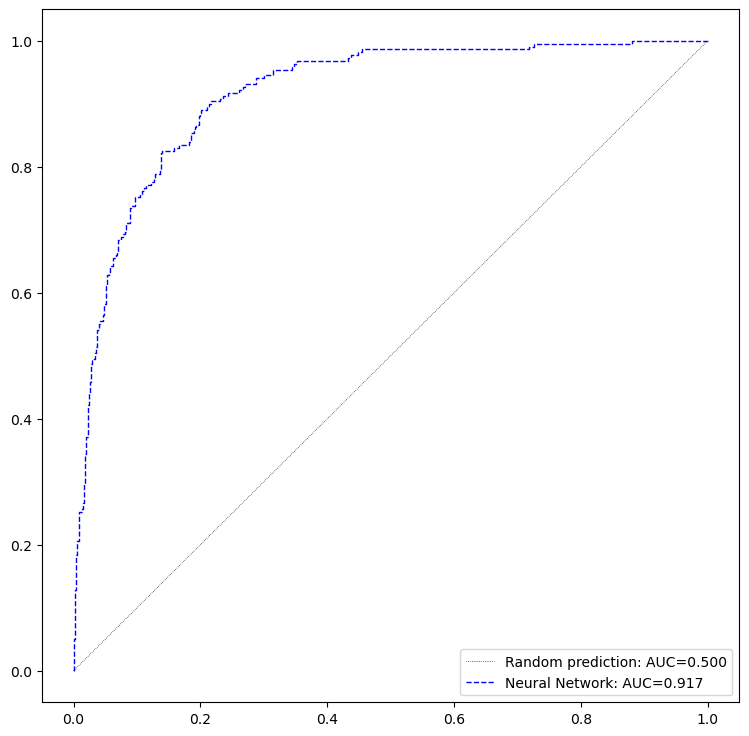

In [106]:
# TODO : Add evaluation / prediction on test data 
#        and get the AUC and other stats plots
from sklearn.metrics import roc_auc_score, roc_curve

BINDER_THRESHOLD=0.426
# Thresholding the targets
y_test_thresholded = (y_test_>=BINDER_THRESHOLD).astype(int)
_, _, _, _, _, _, test_predictions = reloaded_network.forward(x_test_)
test_auc = roc_auc_score(y_test_thresholded.squeeze(), test_predictions.squeeze())
test_fpr, test_tpr, _ = roc_curve(y_test_thresholded.squeeze(), test_predictions.squeeze())

f,a = plt.subplots(1,1 , figsize=(9,9))

a.plot([0,1],[0,1], ls=':', lw=0.5, label='Random prediction: AUC=0.500', c='k')
a.plot(test_fpr, test_tpr, ls='--', lw=1, label=f'Neural Network: AUC={test_auc:.3f}', c='b')
a.legend()

# Testing multiple model sizes and plotting the results:

A convolutional neural network has an additioanl set of hyperparameters relating to its convolutional operator. This gives us more parameters we need to tune during hyperparameter optimization which in turn requires us to train additional models. In the cell below, we have to train 8 models to tune 3 parameters. For more exhaustive searches using larger models, you can see how this number and required compute time can quickly explode. If the cell takes too long to execute, remove one or more of the parameter for loops.

Training model with hidden size : 10
(10, 32) (32,) (32, 1) (1,)
Training model with hidden size : 64
(10, 32) (32,) (32, 1) (1,)


/var/folders/zv/33b_cxqd65s540bqz2grpnqh0000gp/T/ipykernel_79021/990035197.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


Training model with hidden size : 10
(50, 32) (32,) (32, 1) (1,)
Training model with hidden size : 64
(50, 32) (32,) (32, 1) (1,)


/var/folders/zv/33b_cxqd65s540bqz2grpnqh0000gp/T/ipykernel_79021/990035197.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


Training model with hidden size : 10
(10, 32) (32,) (32, 1) (1,)
Training model with hidden size : 64
(10, 32) (32,) (32, 1) (1,)


/var/folders/zv/33b_cxqd65s540bqz2grpnqh0000gp/T/ipykernel_79021/990035197.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


Training model with hidden size : 10
(50, 32) (32,) (32, 1) (1,)
Training model with hidden size : 64
(50, 32) (32,) (32, 1) (1,)


/var/folders/zv/33b_cxqd65s540bqz2grpnqh0000gp/T/ipykernel_79021/990035197.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


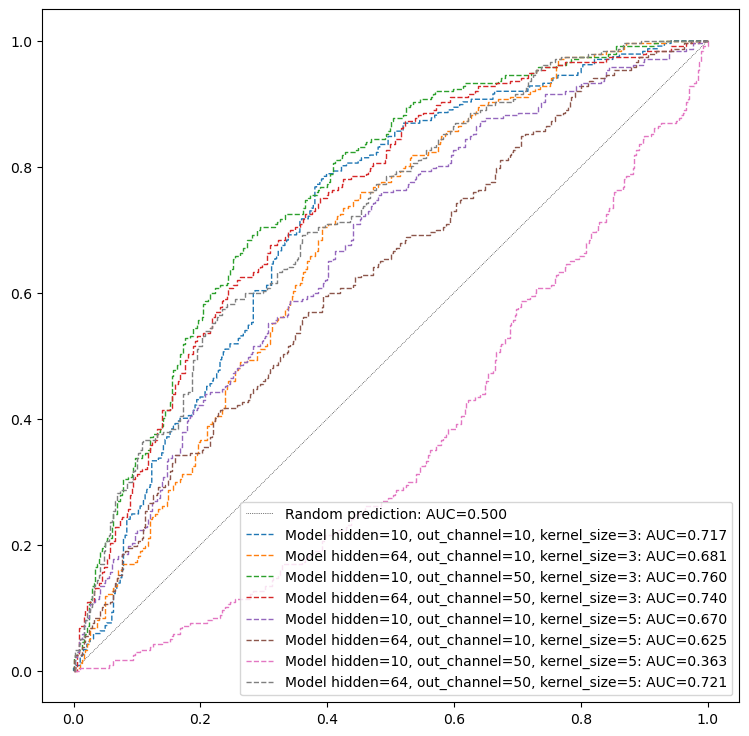

In [36]:
# Training loops
results={}
learning_rate=0.00001
n_epochs = 250


BINDER_THRESHOLD=0.426
# Thresholding the targets
y_test_thresholded = (y_test_>=BINDER_THRESHOLD).astype(int)

f,a = plt.subplots(1,1, figsize=(9,9))
a.plot([0,1],[0,1],ls=':', c='k', lw=0.5, label='Random prediction: AUC=0.500')
for kernel_size in [3, 5]:
    for out_channels in [25, 50]:
        for hidden_size in [32, 64]:
            print(f'Training model with hidden size : {hidden_size}, out_channels : {out_channels}, kernel_size : {kernel_size}')
            model = SimpleCNN(kernel_size=kernel_size, in_channels=input_size, out_channels=out_channels, 
                            hidden_size=hidden_units, output_size=output_size)
            for _ in range(n_epochs):
                train_network(model, x_train_, y_train_, learning_rate)
                _, _, _, _, _, _, test_preds = model.forward(x_test_)
            test_auc = roc_auc_score(y_test_thresholded.squeeze(), test_preds.squeeze())
            test_fpr, test_tpr, _ = roc_curve(y_test_thresholded.squeeze(), test_preds.squeeze())
            a.plot(test_fpr, test_tpr, ls='--', lw=1, label=f'Model hidden={hidden_size}, out_channel={out_channels}, kernel_size={kernel_size}: AUC={test_auc:.3f}')
        a.legend()
        f.show()